## Wykład 7 Jak działa GPT?
### Architektura transformer

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

In [12]:
torch.set_printoptions(precision=2, sci_mode=False)

### Maskowana atencja
* ignorujemy na razie batch size
* w implementacji na laboratorium dochodzi jeszcze batch size jako pierwszy wymiar
* ale to nie zmienia wzorów i implemnetacji (chyba, że omówione dalej)

$$Q = X W_Q,\quad K = X W_K,\quad V = X W_V$$
$$\text{scores} = \frac{QK^{T}}{\sqrt{d_{head}}}$$
$$ \text{mask}_{ij} = 
\begin{cases}
1 & \text{if } j \leq i \\
0 & \text{if } j > i
\end{cases} \qquad \text{macierz trójkątna dolna}$$
$$\text{masked\_scores}_{ij} = \begin{cases}
\text{scores}_{ij} & \text{if } \text{mask}_{ij} = 1 \\
-\infty & \text{if } \text{mask}_{ij} = 0
\end{cases} $$
$$\text{attention} = \text{softmax}\left(\text{masked\_scores}\right)$$
$$ \text{weighted\_values} = \text{attention} \cdot V $$
$$ out = \text{weighted\_values} \cdot W_{out} $$

In [13]:
seq_len = 4
d_model = 6
d_head = 2

In [14]:
# dane wejściowe
x = torch.randn(seq_len, d_model)
x

tensor([[ 1.06, -1.32,  0.72,  0.27, -0.93,  0.54],
        [ 1.27,  0.01,  1.22,  0.74,  1.56,  1.05],
        [-0.33, -0.77, -1.28,  0.59,  0.12, -0.25],
        [ 0.08, -1.28,  0.37, -0.06, -0.59, -1.18]])

Zapytania (quesries $Q$), klucze (keys $K$) i wartości (values $V$):
$$Q = X W_Q,\quad K = X W_K,\quad V = X W_V$$

In [15]:
Wk = nn.Linear(d_model, d_head, bias=False)
Wq = nn.Linear(d_model, d_head, bias=False)
Wv = nn.Linear(d_model, d_head, bias=False)

In [16]:
K = Wk(x)
Q = Wq(x)
V = Wv(x)
print(K.shape)

torch.Size([4, 2])


In [17]:
K

tensor([[-0.36, -0.39],
        [ 0.47, -0.69],
        [ 0.14, -0.06],
        [-0.31,  0.25]], grad_fn=<MmBackward0>)

Dzielenie przez $\sqrt{d_{head}}$ służy normalizacji (za duże wartości powodują, że większość prawdopodobieństwa po softmax jest przypisana do jednej wartości)
$$\text{scores} = \frac{QK^{T}}{\sqrt{d_{head}}}$$

In [18]:
# https://pytorch.org/docs/stable/generated/torch.transpose.html
# Returns a tensor that is a transposed version of input. The given dimensions dim0 and dim1 are swapped.
K.transpose(-2, -1)

tensor([[-0.36,  0.47,  0.14, -0.31],
        [-0.39, -0.69, -0.06,  0.25]], grad_fn=<TransposeBackward0>)

In [19]:
scores = Q @ K.transpose(-2, -1) * d_head ** (-0.5)
print(scores.shape)
print(scores)

torch.Size([4, 4])
tensor([[ 0.15,  0.70,  0.10, -0.30],
        [ 0.18,  0.16, -0.00, -0.04],
        [-0.19,  0.33,  0.09, -0.20],
        [ 0.02,  0.68,  0.11, -0.32]], grad_fn=<MulBackward0>)


Celem stosowania maski jest pominięcie przyszłych elementów sekwencji w predykcji:

$$ \text{mask}_{ij} = 
\begin{cases}
1 & \text{if } j \leq i \\
0 & \text{if } j > i
\end{cases} \qquad \text{macierz trójkątna dolna}$$
$$\text{masked\_scores}_{ij} = \begin{cases}
\text{scores}_{ij} & \text{if } \text{mask}_{ij} = 1 \\
-\infty & \text{if } \text{mask}_{ij} = 0
\end{cases} $$

In [20]:
mask = torch.tril(torch.ones(seq_len, seq_len))
mask

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [21]:
masked_scores = scores.masked_fill(mask == 0, float('-inf'))
masked_scores

tensor([[ 0.15,  -inf,  -inf,  -inf],
        [ 0.18,  0.16,  -inf,  -inf],
        [-0.19,  0.33,  0.09,  -inf],
        [ 0.02,  0.68,  0.11, -0.32]], grad_fn=<MaskedFillBackward0>)

Atencja:
$$\text{attention} = \text{softmax}\left(\text{masked\_scores}\right)$$

In [22]:
attention = F.softmax(masked_scores, dim=-1)
attention

tensor([[1.00, 0.00, 0.00, 0.00],
        [0.50, 0.50, 0.00, 0.00],
        [0.25, 0.42, 0.33, 0.00],
        [0.21, 0.41, 0.23, 0.15]], grad_fn=<SoftmaxBackward0>)

Bierzemy $V$ z wagami wyznaczonymi przez atencję
$$ \text{weighted\_values} = \text{attention} \cdot V $$

In [23]:
V

tensor([[ 0.61,  0.49],
        [-0.13,  1.15],
        [ 0.14, -0.52],
        [ 0.27, -0.55]], grad_fn=<MmBackward0>)

In [24]:
weighted_values = attention @ V
weighted_values

tensor([[0.61, 0.49],
        [0.24, 0.82],
        [0.15, 0.43],
        [0.15, 0.37]], grad_fn=<MmBackward0>)

Przekształcamy ponownie do rozmiaru *d_model*:
$$ out = \text{weighted\_values} \cdot W_{out} $$

In [25]:
Wout = nn.Linear(d_head, d_model, bias=False)

In [26]:
out = Wout(weighted_values)
out

tensor([[ 0.11,  0.04, -0.10,  0.49, -0.06,  0.22],
        [ 0.10,  0.10,  0.19,  0.43, -0.29,  0.39],
        [ 0.05,  0.05,  0.09,  0.24, -0.15,  0.21],
        [ 0.05,  0.04,  0.07,  0.21, -0.12,  0.17]], grad_fn=<MmBackward0>)

### Wymiary
* przetwarzamy dane wejściowe o kształcie *batch_size* x *seq_len*
* potem wewnątrz modelu zamieniamy tokeny na reprezentację wektorową
* i przetwarzamy *batch_size* x *d_model* x *seq_len*
* *d_model* to długość reprezentacji wektorowej dla tokenu

In [27]:
vocab_size = 5
batch_size = 2
seq_len = 3
d_model = 4

In [28]:
X = torch.randint(high=vocab_size, size=(batch_size, seq_len))
X

tensor([[4, 4, 3],
        [2, 0, 3]])

In [29]:
emb = nn.Embedding(vocab_size, d_model) 

In [30]:
x_emb = emb(X)
x_emb

tensor([[[-1.47,  0.91, -0.36, -0.23],
         [-1.47,  0.91, -0.36, -0.23],
         [-1.10,  0.10,  0.92, -0.08]],

        [[-1.10, -1.00,  0.34, -0.07],
         [ 0.50, -1.38,  0.20,  0.14],
         [-1.10,  0.10,  0.92, -0.08]]], grad_fn=<EmbeddingBackward0>)

In [31]:
x_emb.shape

torch.Size([2, 3, 4])

#### Entropia krzyżowa w 3 wymiarach

In [32]:
y = torch.randint(high=vocab_size, size=(batch_size, seq_len))
y

tensor([[4, 4, 2],
        [4, 1, 0]])

In [33]:
logits = torch.randn(batch_size, seq_len, vocab_size)
logits

tensor([[[ 0.33,  0.82,  0.18,  2.91, -0.17],
         [ 0.85,  1.10, -0.44,  0.47, -1.42],
         [-0.44,  0.97, -0.13,  1.53,  0.16]],

        [[ 1.08, -0.08,  0.73,  0.94, -2.15],
         [-0.25, -0.21,  0.24,  0.65,  0.38],
         [ 1.08,  0.05,  0.05, -0.57,  0.68]]])

In [34]:
F.cross_entropy(logits, y)

RuntimeError: Expected target size [2, 5], got [2, 3]

#### Entropia krzyżowa dla większej liczby wymiarów
https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html

* Uwaga: prawdopodobieństwa (logity) muszą mieć wymiar liczba przykładów x liczba klas
* Przekształcamy logity do kształtu (*batch_size* * *seq_len*, *vocab_size*)
* A etykiety do kształtu (*batch_size* * *seq_len*)
* W ten sposób wyznaczamy predykcję i liczymy funkcję straty **dla każdego elementu sekwencji** (nie tylko ostatniego)

In [35]:
# do zmiany wymiaru używamy view
logits.view(batch_size * seq_len, vocab_size)

tensor([[ 0.33,  0.82,  0.18,  2.91, -0.17],
        [ 0.85,  1.10, -0.44,  0.47, -1.42],
        [-0.44,  0.97, -0.13,  1.53,  0.16],
        [ 1.08, -0.08,  0.73,  0.94, -2.15],
        [-0.25, -0.21,  0.24,  0.65,  0.38],
        [ 1.08,  0.05,  0.05, -0.57,  0.68]])

In [36]:
logits.view(batch_size * seq_len, vocab_size).shape

torch.Size([6, 5])

In [37]:
loss = F.cross_entropy(logits.view(batch_size * seq_len, vocab_size), y.view(batch_size * seq_len)) # zmiana kształtu https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
loss

tensor(2.76)

### Module list i sumowanie wyjść

In [38]:
ml = nn.ModuleList([nn.Linear(2, 3) for i in range(4)])

In [39]:
ml

ModuleList(
  (0-3): 4 x Linear(in_features=2, out_features=3, bias=True)
)

In [40]:
ml[0]

Linear(in_features=2, out_features=3, bias=True)

In [41]:
x = torch.randn(2, 2)
x

tensor([[-0.06, -0.02],
        [-0.08, -0.53]])

In [42]:
out = ml[0](x)
out

tensor([[-0.05, -0.56,  0.70],
        [-0.11, -0.91,  0.90]], grad_fn=<AddmmBackward0>)

In [44]:
# stosujemy do x każdą warstwę i sumujemy wyniki
for layer in ml[1:]:
    out += layer(x) 

In [45]:
out

tensor([[-0.04, -0.97,  1.44],
        [-1.40, -1.18,  2.53]], grad_fn=<AddBackward0>)

### Kodowanie pozycyjne (positional embedding)
* Mechanizm atencji odpowiada za kopiowanie wartości podobnych (istotnych tokenów) do bieżącego tokenu
* Ale token nie ma **żadnej informacji** na jakiej pozycji w sekwencji się znajduje
* Rozwiązujemy to porzez dodanie **positional embedding** które koduje **pozycję tokenu**
* Uwaga! Na wejściu tego embeddingu nie ma danych wejściowych (tekstu, tokenów), tylko **numery polejne pozycji w sekwencji**

In [46]:
pos_emb = nn.Embedding(seq_len, d_model)

In [47]:
pos_emb

Embedding(3, 4)

In [48]:
torch.tensor([range(seq_len)])

tensor([[0, 1, 2]])

In [49]:
pos_emb(torch.tensor([range(seq_len)]))

tensor([[[ 0.78, -1.03,  0.40,  0.52],
         [-1.26,  1.04,  0.49,  1.83],
         [ 0.45,  0.91,  0.39, -0.20]]], grad_fn=<EmbeddingBackward0>)

In [50]:
pos_emb(torch.tensor([range(seq_len)])).shape

torch.Size([1, 3, 4])

### Funkcja aktywacji GELU

In [51]:
gelu = nn.GELU()

In [52]:
x = torch.arange(-3, 3, 0.01)

In [53]:
x_gelu = gelu(x)

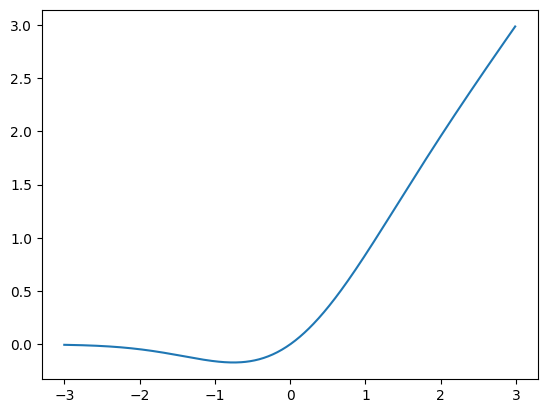

In [54]:
plt.plot(x, x_gelu);

### Umieszczanie warstw po sobie (nn.Sequential)

In [55]:
modules = nn.Sequential(nn.Linear(2, 3), nn.Linear(3, 4))

In [56]:
x = torch.randn(2, 2)
x

tensor([[-0.34,  1.53],
        [ 0.19,  0.85]])

In [57]:
modules(x)

tensor([[-0.30,  0.03, -0.32, -0.51],
        [ 0.03, -0.13, -0.11, -0.11]], grad_fn=<AddmmBackward0>)

### Layer Norm


`nn.LayerNorm(d_model)` normalizuje dane wejściowe wzdłuż ostatniego wymiaru. Dla wektora wejściowego $ x_i \in \mathbb{R}^{d_{\text{model}}}$, wyjście LayerNorm jest obliczane jako:

$$\text{LayerNorm}(x_i) = \gamma \cdot \frac{x_i - \mu_i}{\sqrt{\sigma_i^2 + \varepsilon}} + \beta$$

Gdzie:

- $\mu_i = \frac{1}{d_{\text{model}}} \sum_{j=1}^{d_{\text{model}}} x_{ij}$ to średnia
- $\sigma_i^2 = \frac{1}{d_{\text{model}}} \sum_{j=1}^{d_{\text{model}}} (x_{ij} - \mu_i)^2$ to wariancja 
- $\varepsilon$ to mała stała zapewniająca stabilność numeryczną
- $\gamma$ i $\beta$ to parametry uczące się (domyślnie: $\gamma = 1$, $\beta = 0$)

W rezultacie, po zastosowaniu LayerNorm, każdy wektor $x_i$ będzie miał w przybliżeniu średnią zero i wariancję jednostkową.

In [58]:
# layer norm na slajdy
ln = nn.LayerNorm(d_model)

In [59]:
x = torch.randn(2, d_model)
x

tensor([[ 0.27, -0.03,  0.15,  0.05],
        [ 0.34, -1.46, -1.36, -0.48]])

In [60]:
x_ln = ln(x)
x_ln

tensor([[ 1.42, -1.25,  0.36, -0.53],
        [ 1.48, -0.98, -0.85,  0.36]], grad_fn=<NativeLayerNormBackward0>)

In [61]:
x_ln.sum(axis=1)

tensor([    0.00,     0.00], grad_fn=<SumBackward1>)

In [62]:
x_ln.var(axis=1, unbiased=False)

tensor([1.00, 1.00], grad_fn=<VarBackward0>)

In [63]:
# gamma
ln.weight

Parameter containing:
tensor([1., 1., 1., 1.], requires_grad=True)

In [64]:
# beta
ln.bias

Parameter containing:
tensor([0., 0., 0., 0.], requires_grad=True)